In [ ]:
# Creating synthetic training data by modeling heat dissipation over a bar.

from tqdm import tqdm  # Import tqdm for progress bar
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate the Dataset from the 1D Heat Equation

# Parameters for the 1D heat equation
Nx = 300  # Number of spatial points

num_train_samples = 400  # Training set
num_test_samples = 100   # Test set

# Store parameters for each sample
T_train = np.random.uniform(1.0, 2.0, num_train_samples)  # Total simulation time
L_train = np.random.uniform(0.5, 2.0, num_train_samples)  # Bar length
alpha_train = np.random.uniform(0.001, 0.02, num_train_samples)  # Diffusivity
dx_train = L_train / (Nx - 1)  # Spatial step size per sample
dt_train = 0.99 * (dx_train ** 2) / (2 * alpha_train)  # Time step size per sample
Nt_train = (T_train / dt_train).astype(int)  # Number of time steps per sample

# Do the same for test set
T_test = np.random.uniform(1.0, 2.0, num_test_samples)
L_test = np.random.uniform(0.5, 2.0, num_test_samples)
alpha_test = np.random.uniform(0.001, 0.02, num_test_samples)
dx_test = L_test / (Nx - 1)
dt_test = 0.99 * (dx_test ** 2) / (2 * alpha_test)
Nt_test = (T_test / dt_test).astype(int)

# Heat equation modeling constraint:
# Courant-Friedrichs-Lewy (CFL) Stability condition (explicit finite difference requires dt < dx^2 / (2*alpha))
assert (dt_train < dx_train**2 / (2 * alpha_train)).all(), "Time step is too large; reduce dt or increase dx."
assert (dt_test < dx_test**2 / (2 * alpha_test)).all(), "Time step is too large; reduce dt or increase dx."

X_train = torch.zeros(num_train_samples, Nx)
Y_train = torch.zeros(num_train_samples, Nx) # Final temperature after time T on all Nx samples
X_test = torch.zeros(num_test_samples, Nx)  # New test set
Y_test = torch.zeros(num_test_samples, Nx)  # New test set


# Here we add heat pulsse at a random locations on the bar in each sample.
# Then we use the explicit finite difference method to get the time-stepped temp evolution of the bar for each sample.

# 1-5 heat pulses per sample (left out 0 heat sources case for now due to complexity and breaking the FNO more than wanted for the purposes of the experiment.)
num_sources_train = np.random.choice([1, 2, 3, 4, 5], num_train_samples, p=[1/5, 1/5, 1/5, 1/5, 1/5])
num_sources_test = np.random.randint(1, 6, num_test_samples)

# Adding three types of semi to fairly realistic heat sources; Gaussian to represent a concentrated heat source, sin to represent a fluctuating
# heat source such as thermal wave propogation or periodic external heating due to radiation, & square for a heat source turned on and off.
# Other heat source details:
# Gaussian pulses have randomized width (σ), simulating different spread sizes.
# Sin pulses have randomized frequency and phase shift, creating varied oscillations.
# Square pulses have randomized width and position, modeling sudden heat shocks of different durations.

pulse_types = ["gaussian", "sin", "square"]  # Possible pulse types
centers_train = [torch.tensor(np.random.uniform(0, 1, num_sources_train[i])) for i in range(num_train_samples)]
centers_test = [torch.tensor(np.random.uniform(0, 1, num_sources_test[i])) for i in range(num_test_samples)]

for i in tqdm(range(num_train_samples), desc="Generating Training Data"):
    num_sources = num_sources_train[i]

    # Randomize sample-specific parameters
    L_sample = L_train[i]  # Per-sample length
    T_sample = T_train[i]  # Per-sample total time
    dx_sample = L_sample / (Nx - 1)  # Adjusted spatial step
    alpha_sample = alpha_train[i]  # Per-sample diffusivity
    dt_sample = dt_train[i]  # Already computed in setup
    Nt_sample = Nt_train[i]  # Already computed in setup

    # Define x grid per sample
    x = np.linspace(0, L_sample, Nx)  # Space grid adjusted for `L_sample`
    x = torch.tensor(x, dtype=torch.float32)  # Convert to tensor

    # Initialize u (Temperature array)
    u = np.zeros(Nx)  # Reset temperature distribution for this sample

    X_train[i] = torch.zeros_like(x)  # Adjusted to match per-sample grid

    # Train data
    for _ in range(num_sources):
        pulse_type = random.choice(pulse_types)
        amplitude = np.random.uniform(0, 1)
        center = np.random.uniform(0, L_sample)  # Adjusted to match new `L_sample`

        if pulse_type == "gaussian":
            width = np.random.uniform(0.02, 0.2)
            X_train[i] += amplitude * torch.exp(-((x - center) ** 2) / (2 * width ** 2))

        elif pulse_type == "sin":
            frequency = np.random.uniform(10, 50)
            phase_shift = np.random.uniform(0, 2 * np.pi)
            X_train[i] += amplitude * torch.sin(frequency * np.pi * (x - center) + phase_shift)

        elif pulse_type == "square":
            pulse_width = np.random.uniform(0.05, 0.2)
            X_train[i] += amplitude * (torch.abs(x - center) < pulse_width).float()

    # Simulate heat diffusion with adjusted sample parameters
    u = X_train[i].clone().numpy()
    for n in range(Nt_sample):
        u_new = np.copy(u)
        for j in range(1, Nx - 1):
            u_new[j] = u[j] + alpha_sample * dt_sample / dx_sample**2 * (u[j - 1] - 2 * u[j] + u[j + 1])
        u = u_new

    Y_train[i] = torch.tensor(u, dtype=torch.float32)

# Test Data
for i in tqdm(range(num_test_samples), desc="Generating Test Data"):
    num_sources = num_sources_test[i]

    # Randomize sample-specific parameters independently for the test set
    L_sample = L_test[i]
    T_sample = T_test[i]
    dx_sample = dx_test[i]
    alpha_sample = alpha_test[i]
    dt_sample = dt_test[i]
    Nt_sample = Nt_test[i]

    # Define x grid per sample
    x = np.linspace(0, L_sample, Nx)
    x = torch.tensor(x, dtype=torch.float32)

    # Initialize u (Temperature array)
    u = np.zeros(Nx)  # Reset for each test sample

    X_test[i] = torch.zeros_like(x)  # Adjusted to per-sample grid

    for _ in range(num_sources):
        pulse_type = random.choice(pulse_types)
        amplitude = np.random.uniform(0, 1)
        center = np.random.uniform(0, L_sample)

        if pulse_type == "gaussian":
            width = np.random.uniform(0.02, 0.2)
            X_test[i] += amplitude * torch.exp(-((x - center) ** 2) / (2 * width ** 2))

        elif pulse_type == "sin":
            frequency = np.random.uniform(10, 50)
            phase_shift = np.random.uniform(0, 2 * np.pi)
            X_test[i] += amplitude * torch.sin(frequency * np.pi * (x - center) + phase_shift)

        elif pulse_type == "square":
            pulse_width = np.random.uniform(0.05, 0.2)
            X_test[i] += amplitude * (torch.abs(x - center) < pulse_width).float()

    # Simulate heat diffusion with adjusted sample parameters
    u = X_test[i].clone().numpy()
    for n in range(Nt_sample):
        u_new = np.copy(u)
        for j in range(1, Nx - 1):
            u_new[j] = u[j] + alpha_sample * dt_sample / dx_sample**2 * (u[j - 1] - 2 * u[j] + u[j + 1])
        u = u_new

    Y_test[i] = torch.tensor(u, dtype=torch.float32)

# Add some noise to closer replicate experimental data
noise_level = 0.01  # Adjust as needed (1% of max value)
X_train += noise_level * torch.randn_like(X_train)  # Add Gaussian noise
X_train = torch.clamp(X_train, 0, 1)  # Keep values between 0 and 1
Y_train += noise_level * torch.randn_like(Y_train)
Y_train = torch.clamp(Y_train, 0, 1)  # Keep within [0,1] range

print(X_train.shape)  # Expected: (400, 300)
print(Y_train.shape)  # Expected: (400, 300)
print(X_test.shape)  # Expected: (100,  300)
print(Y_test.shape)  # Expected: (100, 300)

Generating Test Data: 100%|██████████| 100/100 [05:02<00:00,  3.03s/it]

torch.Size([400, 300])
torch.Size([400, 300])


In [ ]:
import datetime
import torch

# Generate a filename with a version number
version = 1  # Start at 1 and increase manually each time
filename = f"training_data{version}.pth"

# Create a dictionary with all data + parameters
data_to_save = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_test": X_test,
    "Y_test": Y_test,
    "T_train": T_train,
    "L_train": L_train,
    "alpha_train": alpha_train,
    "dx_train": dx_train,
    "dt_train": dt_train,
    "Nt_train": Nt_train,
    "T_test": T_test,
    "L_test": L_test,
    "alpha_test": alpha_test,
    "dx_test": dx_test,
    "dt_test": dt_test,
    "Nt_test": Nt_test,
    "Nx": Nx,
    "num_train_samples": num_train_samples,
    "num_test_samples": num_test_samples
}

In [ ]:
from google.colab import drive
import torch
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path
folder_path = "/content/drive/My Drive/ML Projects/FNO Project"

# Confirm the directory exists
os.makedirs(folder_path, exist_ok=True)

# Save the dataset inside the FNO Project folder
save_path = os.path.join(folder_path, "training_data.pth")

print(f"✅ Dataset saved at: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data saved to Google Drive: training_data1.pth


In [ ]:
from google.colab import drive
import torch
import os
import numpy as np

# ✅ Mount Google Drive
drive.mount('/content/drive')

# ✅ Define the folder path
folder_path = "/content/drive/My Drive/ML Projects/FNO Project"
os.makedirs(folder_path, exist_ok=True)  # Ensure directory exists

# ✅ Load first training dataset (training_data1.pth)
load_path_1 = f"{folder_path}/training_data1.pth"
loaded_data_1 = torch.load(load_path_1)

# ✅ Load second training dataset (training_data2.pth)
load_path_2 = f"{folder_path}/training_data2.pth"
loaded_data_2 = torch.load(load_path_2)

# ✅ Unpack training data from both datasets
X_train_1, Y_train_1 = loaded_data_1["X_train"], loaded_data_1["Y_train"]
X_train_2, Y_train_2 = loaded_data_2["X_train"], loaded_data_2["Y_train"]

# Convert numpy arrays to PyTorch tensors where needed
def ensure_tensor(data):
    return torch.tensor(data, dtype=torch.float32) if isinstance(data, np.ndarray) else data

T_train_1 = ensure_tensor(loaded_data_1["T_train"])
L_train_1 = ensure_tensor(loaded_data_1["L_train"])
alpha_train_1 = ensure_tensor(loaded_data_1["alpha_train"])
dx_train_1 = ensure_tensor(loaded_data_1["dx_train"])
dt_train_1 = ensure_tensor(loaded_data_1["dt_train"])
Nt_train_1 = ensure_tensor(loaded_data_1["Nt_train"])

T_train_2 = ensure_tensor(loaded_data_2["T_train"])
L_train_2 = ensure_tensor(loaded_data_2["L_train"])
alpha_train_2 = ensure_tensor(loaded_data_2["alpha_train"])
dx_train_2 = ensure_tensor(loaded_data_2["dx_train"])
dt_train_2 = ensure_tensor(loaded_data_2["dt_train"])
Nt_train_2 = ensure_tensor(loaded_data_2["Nt_train"])

# ✅ Concatenate the training datasets
X_train = torch.cat([X_train_1, X_train_2], dim=0)
Y_train = torch.cat([Y_train_1, Y_train_2], dim=0)
T_train = torch.cat([T_train_1, T_train_2], dim=0)
L_train = torch.cat([L_train_1, L_train_2], dim=0)
alpha_train = torch.cat([alpha_train_1, alpha_train_2], dim=0)
dx_train = torch.cat([dx_train_1, dx_train_2], dim=0)
dt_train = torch.cat([dt_train_1, dt_train_2], dim=0)
Nt_train = torch.cat([Nt_train_1, Nt_train_2], dim=0)

# ✅ Update the number of training samples
num_train_samples = X_train.shape[0]

# ✅ Load test data only from `training_data1.pth`
X_test, Y_test = loaded_data_1["X_test"], loaded_data_1["Y_test"]
T_test = ensure_tensor(loaded_data_1["T_test"])
L_test = ensure_tensor(loaded_data_1["L_test"])
alpha_test = ensure_tensor(loaded_data_1["alpha_test"])
dx_test = ensure_tensor(loaded_data_1["dx_test"])
dt_test = ensure_tensor(loaded_data_1["dt_test"])
Nt_test = ensure_tensor(loaded_data_1["Nt_test"])
num_test_samples = loaded_data_1["num_test_samples"]

print(f"✅ Combined dataset loaded with {num_train_samples} training samples and {num_test_samples} test samples.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined dataset loaded with 1000 training samples and 100 test samples.


<ipython-input-2-7feb26921022>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data_1 = torch.load(load_path_1)
<ipython-input-2-7feb26921022>:19: FutureWarning: Yo

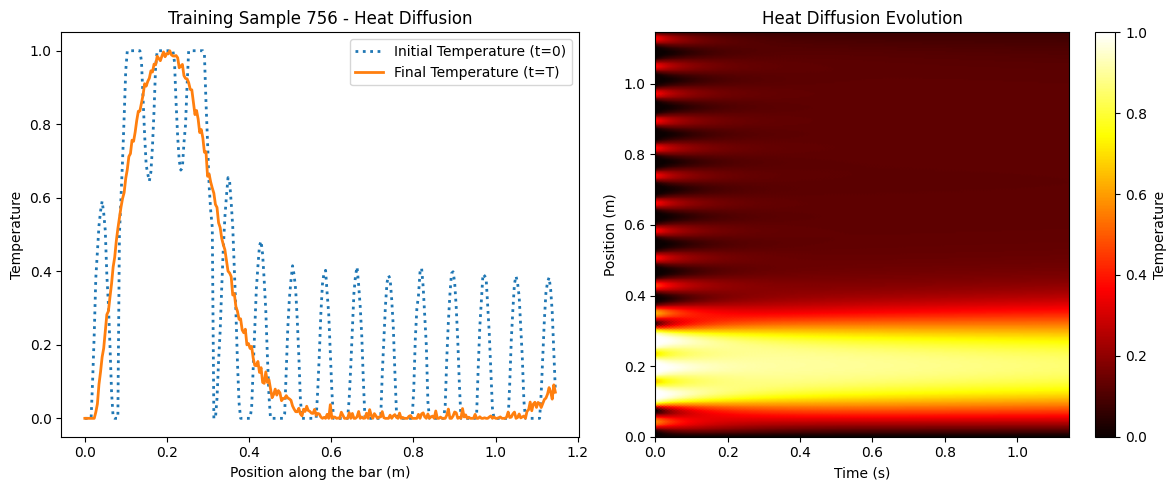

In [ ]:
# Re-load dependencies
from tqdm import tqdm  # Import tqdm for progress bar
import torch
# print(torch.__version__)  # Check PyTorch version

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

Nx = 300

# Select a random training sample index
sample_idx = random.randint(0, num_train_samples - 1)
# Retrieve corresponding parameters
T_sample = T_train[sample_idx]
L_sample = L_train[sample_idx]
alpha_sample = alpha_train[sample_idx]
dx_sample = dx_train[sample_idx]
dt_sample = dt_train[sample_idx]
Nt_sample = int(Nt_train[sample_idx].item())  # Convert Tensor to Python int

# Extract the initial and final temperature distributions
initial_temp = X_train[sample_idx].numpy()
final_temp = Y_train[sample_idx].numpy()

# Recompute full time evolution for visualization
u = initial_temp.copy()
# heatmap_data = np.zeros((Nx, Nt_sample))  # Adjust time dimension
heatmap_data = np.zeros((Nx, int(Nt_sample)))  # Ensure integer type

for n in range(Nt_sample):
    u_new = np.copy(u)
    for j in range(1, Nx - 1):
        u_new[j] = u[j] + alpha_sample * dt_sample / dx_sample**2 * (u[j - 1] - 2 * u[j] + u[j + 1])
    u = u_new
    heatmap_data[:, n] = u  # Store for visualization

# Create side-by-side plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: Initial vs. Final Temperature Profiles
axs[0].plot(np.linspace(0, L_sample, Nx), initial_temp, label="Initial Temperature (t=0)", linestyle="dotted", linewidth=2)
axs[0].plot(np.linspace(0, L_sample, Nx), final_temp, label="Final Temperature (t=T)", linestyle="solid", linewidth=2)
axs[0].set_xlabel("Position along the bar (m)")
axs[0].set_ylabel("Temperature")
axs[0].legend()
axs[0].set_title(f"Training Sample {sample_idx} - Heat Diffusion")

# Right: Heatmap of Temperature Evolution Over Time
cax = axs[1].imshow(heatmap_data[::-1], aspect="auto", cmap="hot", extent=[0, T_sample, 0, L_sample])
fig.colorbar(cax, ax=axs[1], label="Temperature")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Position (m)")
axs[1].set_title("Heat Diffusion Evolution")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Convert to PyTorch dataset format
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

# ✅ Dataset ready for training
len(train_loader), X_train.shape, Y_train.shape

(100, torch.Size([1000, 300]), torch.Size([1000, 300]))

In [ ]:
# Build the Fourier-Neural Operator (FNO) Model, taking u(x,0) as inputs and predicting u(x,T)
# Architecture includes a fourier layer to tansform the data into frequency space, linear layers
# to process the info, and an inverse fourier layer to return to real space.

# Re-import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Fourier Layer**
class FourierLayer(nn.Module):
    """Applies FFT, processes in Fourier space, then returns to real space."""
    def __init__(self, modes):
        super(FourierLayer, self).__init__()
        self.modes = modes  # Number of Fourier modes to keep
        self.scale = 1 / (modes * modes)  # Normalization factor

        # Weight matrices for frequency space (complex numbers)
        self.weights_real = nn.Parameter(self.scale * torch.rand(modes, dtype=torch.float32))
        self.weights_imag = nn.Parameter(self.scale * torch.rand(modes, dtype=torch.float32))

    def forward(self, x):
        # Apply FFT (Fast Fourier Transform)
        x_ft = torch.fft.fft(x, dim=-1)

        # Extract real and imaginary parts
        real, imag = x_ft.real, x_ft.imag

        # Multiply with trainable weights (Fourier coefficients)
        real_filtered = real[:, :self.modes] * self.weights_real - imag[:, :self.modes] * self.weights_imag
        imag_filtered = real[:, :self.modes] * self.weights_imag + imag[:, :self.modes] * self.weights_real

        # Reconstruct complex tensor and apply inverse FFT
        x_ft_filtered = torch.zeros_like(x_ft, dtype=torch.cfloat)  # Ensure complex dtype
        x_ft_filtered[:, :self.modes] = torch.complex(real_filtered, imag_filtered)
        x_out = torch.fft.ifft(x_ft_filtered, dim=-1).real

        return x_out

# Define the full FNO model
class FNO1D(nn.Module):
    def __init__(self, modes, hidden_width, output_width):
        super(FNO1D, self).__init__()
        self.fourier_layer = FourierLayer(modes)
        self.fc1 = nn.Linear(output_width, hidden_width)  # Reduce hidden width
        self.fc2 = nn.Linear(hidden_width, hidden_width)
        self.fc3 = nn.Linear(hidden_width, hidden_width)
        self.fc4 = nn.Linear(hidden_width, output_width)  # Output must still be Nx

    def forward(self, x):
        x = self.fourier_layer(x)  # Apply Fourier transformation
        x = F.relu(self.fc1(x))  # Process with dense layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (should match Nx)
        return x

# Initialize the model
Nx = 300
modes = 24  # Number of Fourier modes
hidden_width = 128
output_width = Nx # Matches the number of spatial points Nx

fno_model = FNO1D(modes, hidden_width, output_width)
fno_model

FNO1D(
  (fourier_layer): FourierLayer()
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=300, bias=True)
)

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

# Re-import necessary libraries
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(fno_model.parameters(), lr=0.0005)  # Adam optimizer

# Training loop
num_epochs = 1500  # Number of training epochs
train_losses = []  # Store training losses

# Initialize tqdm progress bar
progress_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch,")

for epoch in progress_bar:
    running_loss = 0.0

    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()  # Zero the gradient buffers

        # Forward pass
        outputs = fno_model(X_batch)

        # Compute loss
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Training complete!
print("Training finished.")
torch.save(fno_model.state_dict(), "fno_model.pth")

Training Progress:   7%|▋         | 100/1500 [00:26<06:27,  3.61epoch,/s]


Epoch [100/1500], Loss: 0.002528


Training Progress:  13%|█▎        | 200/1500 [00:50<05:21,  4.05epoch,/s]


Epoch [200/1500], Loss: 0.001069


Training Progress:  20%|██        | 300/1500 [01:15<05:16,  3.79epoch,/s]


Epoch [300/1500], Loss: 0.000614


Training Progress:  27%|██▋       | 400/1500 [01:42<04:30,  4.06epoch,/s]


Epoch [400/1500], Loss: 0.000504


Training Progress:  33%|███▎      | 500/1500 [02:09<04:05,  4.07epoch,/s]


Epoch [500/1500], Loss: 0.000454


Training Progress:  40%|████      | 600/1500 [02:36<04:01,  3.73epoch,/s]


Epoch [600/1500], Loss: 0.000323


Training Progress:  47%|████▋     | 700/1500 [03:04<03:30,  3.80epoch,/s]


Epoch [700/1500], Loss: 0.000286


Training Progress:  53%|█████▎    | 800/1500 [03:32<03:14,  3.59epoch,/s]


Epoch [800/1500], Loss: 0.000320


Training Progress:  60%|██████    | 900/1500 [04:01<03:08,  3.19epoch,/s]


Epoch [900/1500], Loss: 0.000243


Training Progress:  67%|██████▋   | 1000/1500 [04:30<02:21,  3.54epoch,/s]


Epoch [1000/1500], Loss: 0.000279


Training Progress:  73%|███████▎  | 1100/1500 [04:59<01:53,  3.53epoch,/s]


Epoch [1100/1500], Loss: 0.000390


Training Progress:  80%|████████  | 1200/1500 [05:27<01:23,  3.59epoch,/s]


Epoch [1200/1500], Loss: 0.000215


Training Progress:  87%|████████▋ | 1300/1500 [05:56<01:00,  3.32epoch,/s]


Epoch [1300/1500], Loss: 0.000241


Training Progress:  93%|█████████▎| 1400/1500 [06:23<00:28,  3.55epoch,/s]


Epoch [1400/1500], Loss: 0.000243


Training Progress: 100%|██████████| 1500/1500 [06:50<00:00,  3.65epoch,/s]


Epoch [1500/1500], Loss: 0.000156
Training finished.


In [ ]:
# Dataset ready to test
import torch
# Create the test DataLoader
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)  # No shuffle for test
len(test_loader), X_test.shape, Y_test.shape

(10, torch.Size([100, 300]), torch.Size([100, 300]))

In [ ]:
import torch

# Evaluate Model on Test Set & Compute Test Loss
test_losses = []
with torch.no_grad():
    running_test_loss = 0.0

    for X_test_batch, Y_test_batch in test_loader:
        Y_test_pred = fno_model(X_test_batch)  # Predict with FNO
        test_loss = criterion(Y_test_pred, Y_test_batch)  # Compute test loss
        running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Test Loss: {avg_test_loss:.6f}")

Test Loss: 0.064666


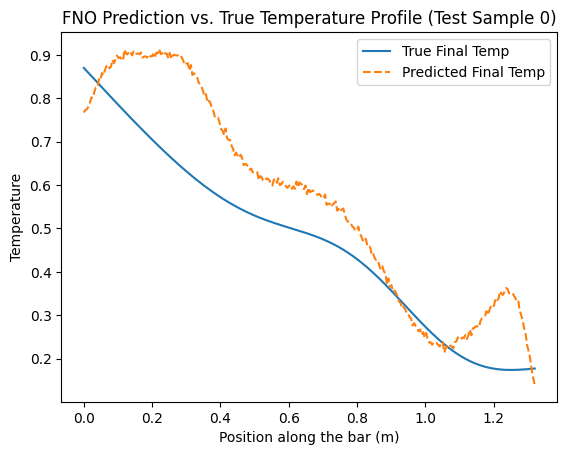

In [ ]:
with torch.no_grad():
    # Randomly select a test sample index
    sample_idx = random.randint(0, num_test_samples - 1)

    # Retrieve corresponding parameters
    T_sample = T_test[sample_idx]
    L_sample = L_test[sample_idx]

    # Extract initial test condition
    X_test_sample = X_test[sample_idx].unsqueeze(0)  # Add batch dimension
    Y_true_sample = Y_test[sample_idx]

    # Get FNO prediction
    Y_pred_sample = fno_model(X_test_sample).squeeze(0)  # Rem"ove batch dimension

    # **Plot true vs predicted final temperature**
    plt.plot(np.linspace(0, L_sample, Nx), Y_true_sample.numpy(), label="True Final Temp")
    plt.plot(np.linspace(0, L_sample, Nx), Y_pred_sample.numpy(), linestyle="dashed", label="Predicted Final Temp")
    plt.title(f"FNO Prediction vs. True Temperature Profile (Test Sample {sample_idx})")
    plt.xlabel("Position along the bar (m)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

In [ ]:
import numpy as np

# Compute absolute and relative error
with torch.no_grad():
    all_errors = []
    all_rel_errors = []

    for X_test_batch, Y_test_batch in test_loader:
        Y_test_pred = fno_model(X_test_batch)  # Predict
        error = torch.abs(Y_test_pred - Y_test_batch)  # Absolute error
        rel_error = error / (Y_test_batch + 1e-6)  # Relative error (avoid div by zero)

        all_errors.append(error.numpy())
        all_rel_errors.append(rel_error.numpy())

# Convert lists to arrays for analysis
all_errors = np.concatenate(all_errors, axis=0)
all_rel_errors = np.concatenate(all_rel_errors, axis=0)


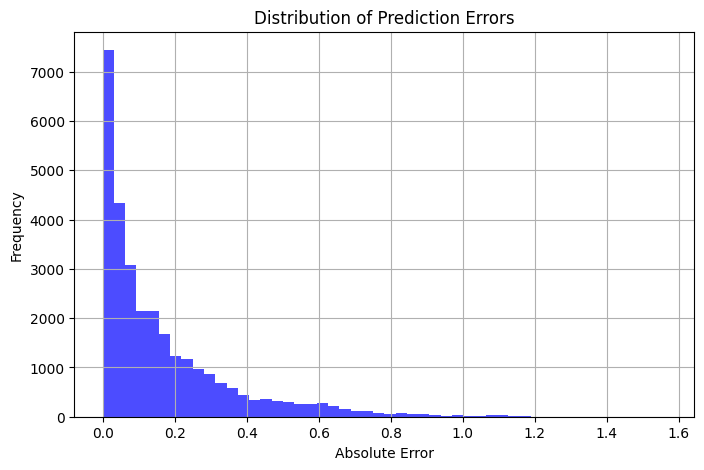

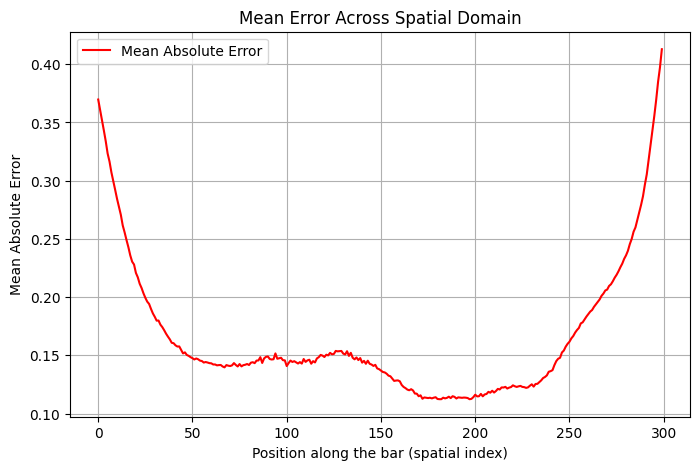

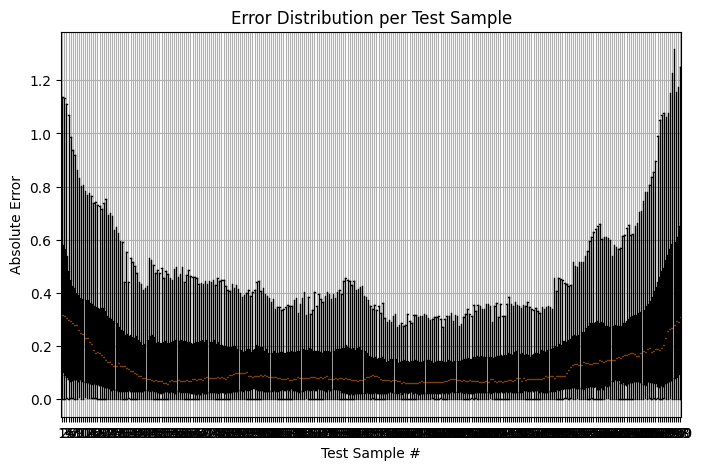

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(all_errors.flatten(), bins=50, alpha=0.7, color="blue")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid()
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(np.mean(all_errors, axis=0), label="Mean Absolute Error", color="red")
plt.xlabel("Position along the bar (spatial index)")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Error Across Spatial Domain")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(8, 5))
plt.boxplot(all_errors, vert=True, showfliers=False)
plt.xlabel("Test Sample #")
plt.ylabel("Absolute Error")
plt.title("Error Distribution per Test Sample")
plt.grid()
plt.show()

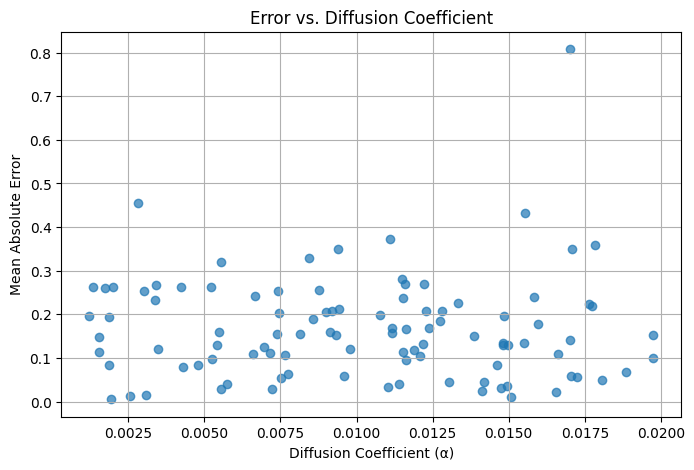

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(alpha_test, all_errors.mean(axis=1), alpha=0.7)
plt.xlabel("Diffusion Coefficient (α)")
plt.ylabel("Mean Absolute Error")
plt.title("Error vs. Diffusion Coefficient")
plt.grid()
plt.show()

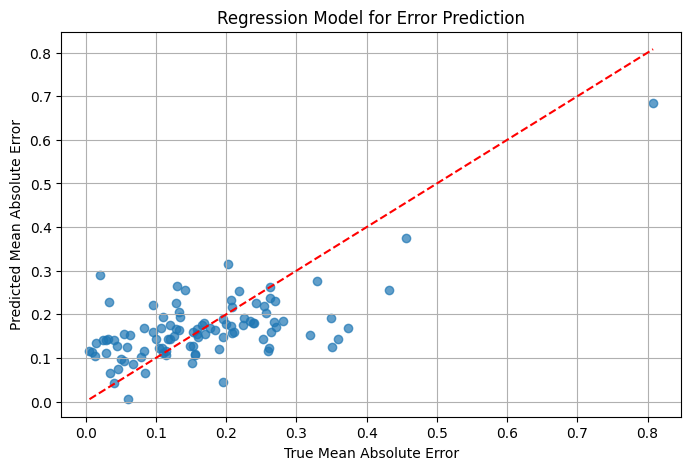

R Score: 0.4440
MAE of Error Prediction: 0.067430


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Define input features for regression (use test parameters)
X_features = np.column_stack([alpha_test, T_test, L_test])  # Features: α, T, L
y_error = all_errors.mean(axis=1)  # Target: Mean error per sample

# Polynomial Regression
poly = PolynomialFeatures(degree=6, include_bias=False)
X_poly = poly.fit_transform(X_features)

# Fit regression model
regressor = LinearRegression()
regressor.fit(X_poly, y_error)

# Predict error trends
y_pred = regressor.predict(X_poly)

r2 = r2_score(y_error, y_pred)
mae = mean_absolute_error(y_error, y_pred)

# Plot Predictions vs Actual Errors
plt.figure(figsize=(8, 5))
plt.scatter(y_error, y_pred, alpha=0.7)
plt.xlabel("True Mean Absolute Error")
plt.ylabel("Predicted Mean Absolute Error")
plt.title("Regression Model for Error Prediction")
plt.plot([y_error.min(), y_error.max()], [y_error.min(), y_error.max()], 'r--')  # y=x line
plt.grid()
plt.show()
print(f"R Score: {r2:.4f}")
print(f"MAE of Error Prediction: {mae:.6f}")

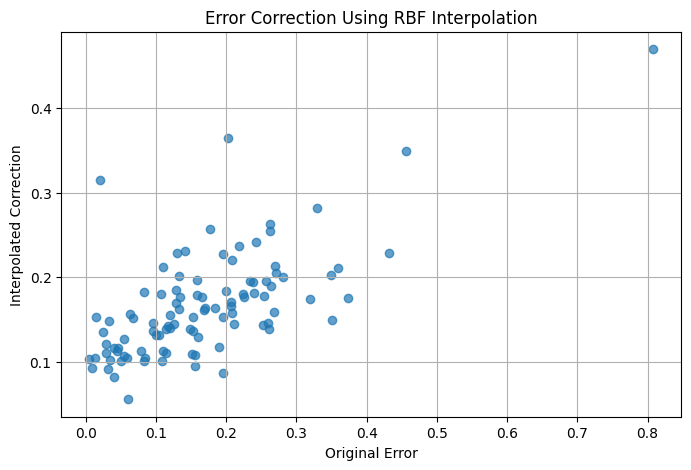

R Score: 0.4440
MAE of Error Prediction: 0.067430


In [ ]:
from scipy.interpolate import RBFInterpolator

# Fit RBF interpolator on known errors
rbf_interp = RBFInterpolator(X_features, y_error, smoothing=0.1)

# Compute correction for test set
error_correction = rbf_interp(X_features)
error_correction_batch = error_correction[: Y_test_pred.shape[0], None]  # Adjust batch


# Apply correction to model predictions
Y_test_corrected = Y_test_pred.numpy() - error_correction_batch

# Compute R^2 and MAE for the RBF Interpolator
r2_rbf = r2_score(y_error, error_correction)
mae_rbf = mean_absolute_error(y_error, error_correction)

# Compare corrected results
plt.figure(figsize=(8, 5))
plt.scatter(y_error, error_correction, alpha=0.7)
plt.xlabel("Original Error")
plt.ylabel("Interpolated Correction")
plt.title("Error Correction Using RBF Interpolation")
plt.grid()
plt.show()
print(f"R Score: {r2:.4f}")
print(f"MAE of Error Prediction: {mae:.6f}")

In [ ]:
import torch.nn as nn
import torch.optim as optim

class ErrorCorrectionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ErrorCorrectionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (regression output)
        return x

# Instantiate model with corrected input size
error_model = ErrorCorrectionNN(input_size=600, hidden_size=128, output_size=300)

In [ ]:
# Compute predictions for the full test set

all_Y_test_pred = []

with torch.no_grad():
    for X_test_batch in test_loader:
        Y_test_pred_batch = fno_model(X_test_batch[0])  # Extract the tensor from tuple
        all_Y_test_pred.append(Y_test_pred_batch)

# Stack all batch predictions into one tensor
Y_test_pred = torch.cat(all_Y_test_pred, dim=0)  # Shape should now match Y_test

# Ensure shapes match before computing error
assert Y_test.shape == Y_test_pred.shape, f"Shape mismatch: {Y_test.shape} vs {Y_test_pred.shape}"

# Compute error
error_targets = (Y_test - Y_test_pred).detach()  # True error values

# Concatenate X_test and Y_test_pred as input features for error model
error_inputs = torch.cat([X_test, Y_test_pred], dim=1)  # Shape: (num_test_samples, 2*Nx)

# Create TensorDataset
error_dataset = torch.utils.data.TensorDataset(error_inputs, error_targets)
error_loader = torch.utils.data.DataLoader(error_dataset, batch_size=10, shuffle=True)

In [ ]:
# Define loss and optimizer
error_criterion = nn.MSELoss()
error_optimizer = optim.Adam(error_model.parameters(), lr=0.001)

num_epochs = 1000  # Can be adjusted based on performance
error_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for error_input_batch, error_target_batch in error_loader:
        error_optimizer.zero_grad()

        # Forward pass
        error_pred = error_model(error_input_batch)

        # Compute loss
        loss = error_criterion(error_pred, error_target_batch)

        # Backward pass
        loss.backward()
        error_optimizer.step()

        running_loss += loss.item()

    # Store and print loss every 50 epochs
    avg_loss = running_loss / len(error_loader)
    error_losses.append(avg_loss)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Error Correction Loss: {avg_loss:.6f}")

# Save the trained model
torch.save(error_model.state_dict(), "error_correction_model.pth")

Epoch [50/1000], Error Correction Loss: 0.001254
Epoch [100/1000], Error Correction Loss: 0.000363
Epoch [150/1000], Error Correction Loss: 0.000865
Epoch [200/1000], Error Correction Loss: 0.000470
Epoch [250/1000], Error Correction Loss: 0.000371
Epoch [300/1000], Error Correction Loss: 0.000150
Epoch [350/1000], Error Correction Loss: 0.000549
Epoch [400/1000], Error Correction Loss: 0.000472
Epoch [450/1000], Error Correction Loss: 0.000186
Epoch [500/1000], Error Correction Loss: 0.001768
Epoch [550/1000], Error Correction Loss: 0.000419
Epoch [600/1000], Error Correction Loss: 0.000135
Epoch [650/1000], Error Correction Loss: 0.001438
Epoch [700/1000], Error Correction Loss: 0.000048
Epoch [750/1000], Error Correction Loss: 0.000244
Epoch [800/1000], Error Correction Loss: 0.000522
Epoch [850/1000], Error Correction Loss: 0.000194
Epoch [900/1000], Error Correction Loss: 0.000535
Epoch [950/1000], Error Correction Loss: 0.000182
Epoch [1000/1000], Error Correction Loss: 0.000129


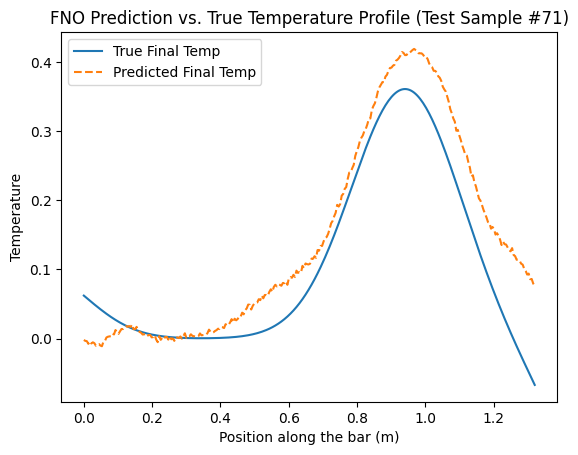

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

with torch.no_grad():
    # Randomly select a batch
    test_batches = list(test_loader)  # Convert DataLoader to list of batches
    batch_idx = random.randint(0, len(test_batches) - 1)  # Random batch index
    X_batch, Y_batch = test_batches[batch_idx]  # Get that batch

    # Randomly select a sample within the batch
    local_idx = random.randint(0, X_batch.shape[0] - 1)  # Random index in batch
    global_idx = batch_idx * X_batch.shape[0] + local_idx  # Compute global sample index

    # Get FNO model prediction for the selected batch
    Y_pred = fno_model(X_batch)

    # Define x grid per sample
    x = np.linspace(0, L_sample, Nx)
    x = torch.tensor(x, dtype=torch.float32)

    plt.plot(x, Y_batch[local_idx].numpy(), label="True Final Temp")
    plt.plot(x, Y_pred[local_idx].numpy(), linestyle="dashed", label="Predicted Final Temp")

    # **Updated Title to Show Global Test Index**
    plt.title(f"FNO Prediction vs. True Temperature Profile (Test Sample #{global_idx + 1})")  # +1 for human-readable index
    plt.xlabel("Position along the bar (m)")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()

 The goal here is to later demonstrate systematic error correction, so we want the FNO to perform just poorly enough that its errors are predictable and improvable with regression or a second NN. We may also want to take the case where the FNO is performing very badly (this may help exaggerate the benefit of the error correction technique and make it very obvious if it works in this case) or at almost 90%+ correctly to show that the error correction technique (if it can) can work at higher and lower error rates. Further, this may help show this method can be used in a more general sense as a post-processing method for other PDE-based problems, especially those utilizing FNOs.

 	•	If we quantify where the FNO fails, we can predict errors in other physics-based applications (e.g., weather models, fluid dynamics, semiconductor modeling).
	•	It's possible that systematic FNO error correction could be a cheap alternative to training deeper or more expensive FNOs.

  Some things we may want to measure:
  We want to measure:
	•	Error trends across different initial conditions (i.e., do errors depend on heat source placement?).
	•	Error trends vs. diffusivity α (does the FNO struggle when α is small vs. large?).
	•	Error trends over space (e.g., does it always underestimate at the boundaries?).

This could be useful for any PDE-based problem:
	•	If we learn how FNO error depends on α, we might predict errors in weather modeling (where α could be turbulence strength).
	•	If boundary errors are systematic, this could be useful in fluid dynamics (where FNOs struggle at domain edges).
	•	If FNO struggles at high-frequency heat sources, that could impact semiconductor modeling.

Takeaway: We’re trying to generalize error correction strategies beyond just heat diffusion. Instead of just making a better FNO, we’re understanding how error behaves across physics-based problems.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.interpolate import UnivariateSpline

# Convert test data to numpy
X_test_np = X_test.numpy()
Y_test_np = Y_test.numpy()
Y_test_pred_np = Y_test_pred.numpy()

# Compute actual error
error_actual = Y_test_np - Y_test_pred_np

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_test_np.reshape(-1, Nx), error_actual.reshape(-1, Nx))
error_pred_lin = lin_reg.predict(X_test_np.reshape(-1, Nx))

# Polynomial Regression
poly_reg = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
poly_reg.fit(X_test_np.reshape(-1, Nx), error_actual.reshape(-1, Nx))
error_pred_poly = poly_reg.predict(X_test_np.reshape(-1, Nx))

# Spline Interpolation
splines = [UnivariateSpline(x, error_actual[i], s=0.1) for i in range(len(error_actual))]
error_pred_spline = np.array([splines[i](x) for i in range(len(error_actual))])

# Apply Corrections
Y_test_corrected_lin = Y_test_pred_np + error_pred_lin
Y_test_corrected_poly = Y_test_pred_np + error_pred_poly
Y_test_corrected_spline = Y_test_pred_np + error_pred_spline

# Save precomputed results for quick access
regression_corrections = {
    "Y_test_corrected_lin": Y_test_corrected_lin,
    "Y_test_corrected_poly": Y_test_corrected_poly,
    "Y_test_corrected_spline": Y_test_corrected_spline
}
torch.save(regression_corrections, "regression_corrections.pth")

print("Regression corrections saved successfully.")

<ipython-input-82-b296d3a6c4c8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_corrections = torch.load("nn_corrected_predictions.pth")
<ipython-input-82-b296d3a6c4c8>:

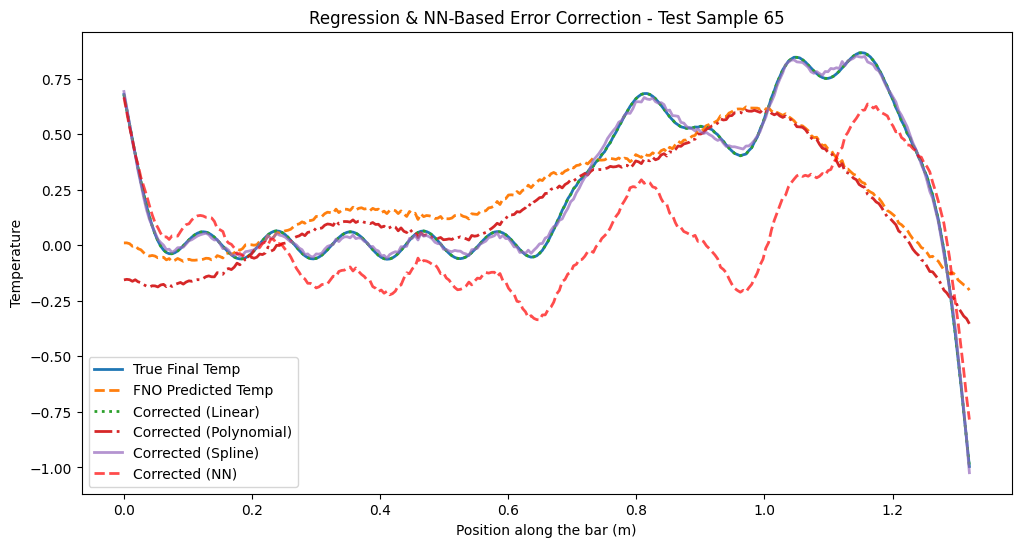

In [ ]:
with torch.no_grad():
    Y_test_corrected_nn = error_model(torch.cat([X_test, Y_test_pred], dim=1))
torch.save(Y_test_corrected_nn, "nn_corrected_predictions.pth")
nn_corrections = torch.load("nn_corrected_predictions.pth")
with torch.no_grad():
    Y_test_corrected_nn = error_model(torch.cat([X_test, Y_test_pred], dim=1))

# Save for visualization later
torch.save(Y_test_corrected_nn, "nn_corrected_predictions.pth")
import torch
import matplotlib.pyplot as plt

# **Load precomputed corrections**
regression_corrections = torch.load("regression_corrections.pth")
nn_corrections = torch.load("nn_corrected_predictions.pth")  # Load NN corrected predictions

# Select a random test sample
sample_idx = np.random.randint(0, len(Y_test))

plt.figure(figsize=(12, 6))
plt.plot(x, Y_test_np[sample_idx], label="True Final Temp", linewidth=2)
plt.plot(x, Y_test_pred_np[sample_idx], linestyle="dashed", label="FNO Predicted Temp", linewidth=2)
plt.plot(x, regression_corrections["Y_test_corrected_lin"][sample_idx], linestyle="dotted", label="Corrected (Linear)", linewidth=2)
plt.plot(x, regression_corrections["Y_test_corrected_poly"][sample_idx], linestyle="dashdot", label="Corrected (Polynomial)", linewidth=2)
plt.plot(x, regression_corrections["Y_test_corrected_spline"][sample_idx], linestyle="solid", label="Corrected (Spline)", linewidth=2, alpha=0.7)
plt.plot(x, nn_corrections[sample_idx].numpy(), linestyle="dashed", label="Corrected (NN)", linewidth=2, alpha=0.7, color="red")

plt.xlabel("Position along the bar (m)")
plt.ylabel("Temperature")
plt.legend()
plt.title(f"Regression & NN-Based Error Correction - Test Sample {sample_idx}")
plt.show()